In [1]:
# Import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(8)

In [2]:
# Download CIFAR10 dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

# Preparing data for training with DataLoaders
from torch.utils.data import DataLoader
loaders = {
    'train': torch.utils.data.DataLoader(
        train_data, batch_size=100, shuffle=True),
    'test': torch.utils.data.DataLoader(
        test_data, batch_size=100, shuffle=False)}

# Define the Singe Layer Neural Network model class
import torch.nn as nn
import torch.nn.functional as F
class SimpleNN(nn.Module):
    # Specify the components to be created automatically upon instantiation
    def __init__(self, num_nodes, num_classes=10):
        super(SimpleNN, self).__init__()
        # The single fully connected layer
        self.fc = nn.Linear(1 * 28 * 28, num_nodes)
        # The final fully connected layer which outputs 10 classes
        self.out = nn.Linear(num_nodes, num_classes)
    # Specify the flow of information
    def forward(self, x):
        # Flatten all dimensions except for the batch size
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc(x))
        output = self.out(x)
        return output


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
from torch import optim

model = SimpleNN(num_nodes=1000)
cost_func = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(), lr = 0.01)   


In [4]:
# Define the training function
def train(model, loaders, verbose=True):
    # Control the behavior of certain layers by specifying the training mode
    model.train()
    # Extract the total number of images to track training progress
    total_img = len(loaders['train'].dataset)
    # Extract and iterate through each batch of training data
    for batch, (X, y) in enumerate(loaders['train']):
        # Pass to GPU for faster processing
        X, y = X.to(device), y.to(device)
        # Call the forward method (under the hood) to produce prediction
        pred = model(X)               
        # Calculate the current cost
        cost = cost_func(pred, y)
        # Clear existing gradients
        optimizer.zero_grad()           
        # Perform backpropagation and compute gradients 
        cost.backward()    
        # Update weights using SGD
        optimizer.step()       
        # Print cost at every 100th batch; each batch has 100 image-label pairs
        if(verbose):
            if batch % 100 == 0:
                loss, current_img_idx = cost.item(), batch * len(X)
                print(f"cost: {cost:>7f}  [{current_img_idx:>5d}/{total_img:>5d}]")      

# Define the test function
def check_accuracy(model, loaders, verbose=True, type="train"):
    # Control the behavior of certain layers by specifying the evaluation mode
    model.eval()
    # Extract the total number of images to in the test set
    total_img = len(loaders[type].dataset)
    correct = 0
    # Disable gradient calculation
    with torch.no_grad():
        for X, y in loaders[type]:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # Add the correct prediction for each batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= total_img
    if verbose:
        print(f"{type} accuracy: {correct:>0.3f}")

    return correct

# test(model, loaders)

In [5]:
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 500
final_train_acc = []
final_test_acc = []
num_nodes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

for n_node in num_nodes:
    print(f"------NODE: {n_node}-----")
    model = SimpleNN(num_nodes=n_node)
    cost_func = nn.CrossEntropyLoss()  
    optimizer = optim.SGD(model.parameters(), lr = 0.01)   
    # start training
    for t in range(num_epochs):
        if t % 10 == 0:
            print(f"Epoch {t}")
        train(model, loaders, verbose=False)
    # save final accuracy
    final_train_acc.append(check_accuracy(model, loaders, type='train'))
    final_test_acc.append(check_accuracy(model, loaders, type='test'))
    
    with open(f"final_train_acc_{n_node}.txt", "wb") as fp: 
        pickle.dump(final_train_acc, fp)

    with open(f"final_test_acc_{n_node}.txt", "wb") as fp: 
        pickle.dump(final_test_acc, fp)


------NODE: 2-----
Epoch 0


TypeError: ignored

In [6]:
with open("final_train_acc_4096.txt", "rb") as fp:
    train = pickle.load(fp)
with open("final_test_acc_4096.txt", "rb") as fp:
    test = pickle.load(fp)
train = [np.around(1-i,3) for i in train]
test = [np.around(1-i,3) for i in test]

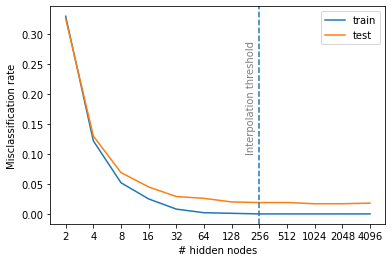

In [7]:
import matplotlib.pyplot as plt
import numpy as np
x_axis = range(len(num_nodes))
plt.plot(x_axis, train, label = "train")
plt.plot(x_axis, test, label = "test")
plt.xticks(x_axis, num_nodes)
plt.axvline(x=x_axis[train.index(0)], ls='--')
plt.text(x_axis[train.index(0)] - 0.2, 0.1, 'Interpolation threshold',
        fontsize = 10, color = 'gray',
        rotation = 90, rotation_mode='anchor')
plt.xlabel("# hidden nodes")
plt.ylabel("Misclassification rate")
plt.legend()
plt.show()